In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [20]:
submission = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
test = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
validation = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [21]:
train.drop_duplicates()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [22]:
train['label'].value_counts()
# 0 - Human written
# 1 - AI generated

label
0    27371
1    17497
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x7d8c710a14e0>,
 [Text(0, 0, 'Human-written'), Text(1, 0, 'AI-generated')])

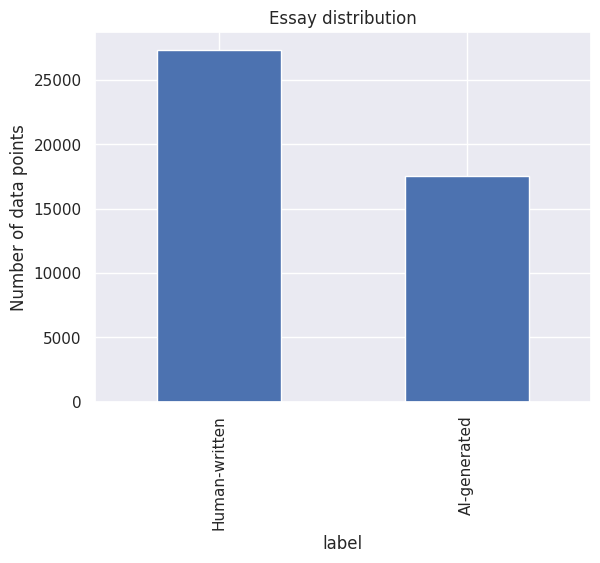

In [23]:
train['label'].value_counts().plot(kind="bar", title="Essay distribution" ,ylabel="Number of data points")
plt.xticks([0, 1], ['Human-written', 'AI-generated'])

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


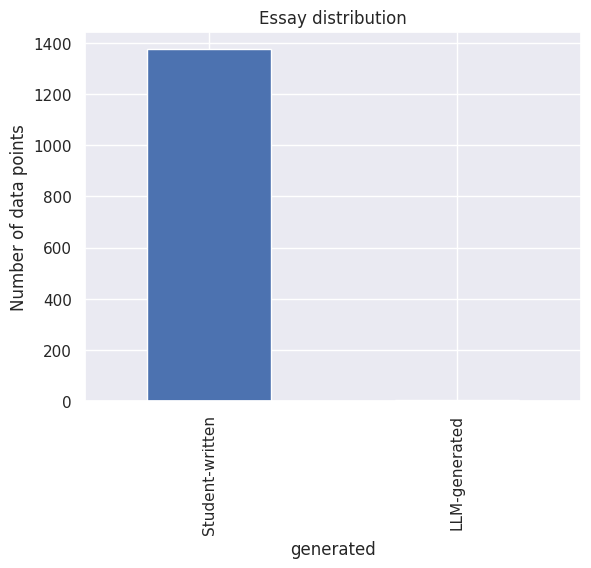

In [24]:
validation['generated'].value_counts().plot(kind="bar", title="Essay distribution" ,ylabel="Number of data points")
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])

validation[validation['generated']==1]
# implying higly imbalanced data

In [25]:
train['essay_length']=train['text'].apply(len)
train

,text,label,prompt_name,source,RDizzl3_seven,essay_length
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,2029
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,2141
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,1044
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,1243
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,1911
...,...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,2239
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,2109
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,1599
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,1454


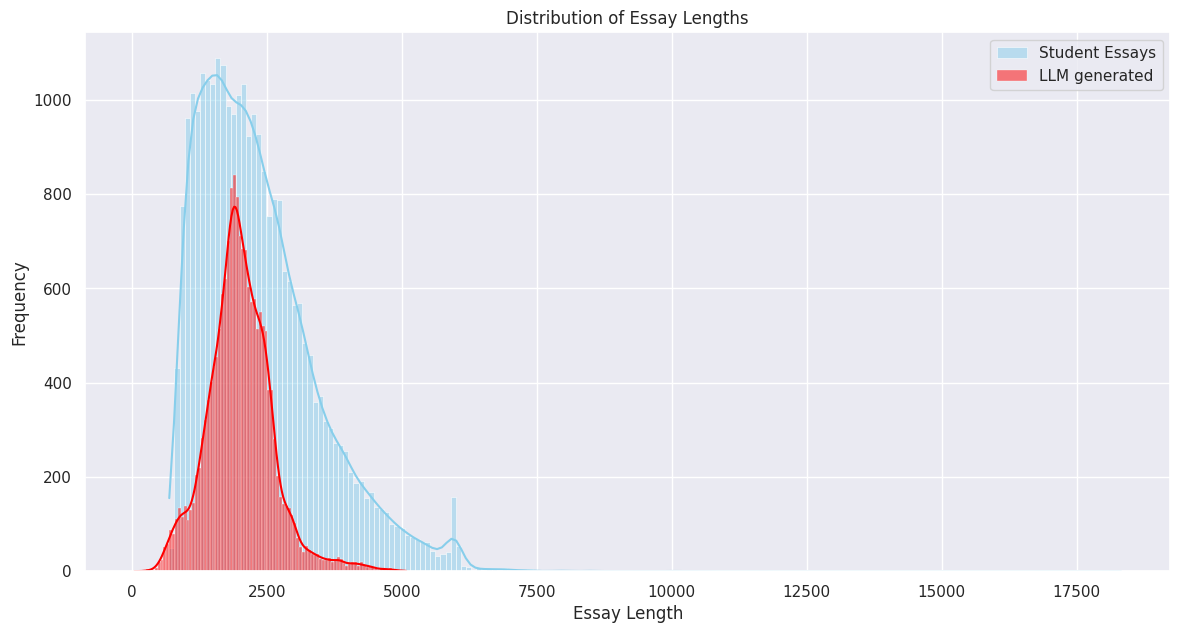

In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(14, 7))
sns.histplot(train[train['label']==0]['essay_length'], color='skyblue', label='Student Essays', kde=True)
sns.histplot(train[train['label']==1]['essay_length'], color='red', label='LLM generated', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [27]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [28]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
dataset = Dataset.from_pandas(test[['text']])

def train_corp_iter(): 
    """
    A generator function for iterating over a dataset in chunks.
    """    
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
        
# Training from iterator REMEMBER it's training on test set...
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_test = []

for text in tqdm(test['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []

for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44868 [00:00<?, ?it/s]

In [29]:
def dummy(text):
    return text

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')

vectorizer.fit(tokenized_texts_test)

# Getting vocab
vocab = vectorizer.vocabulary_

print(vocab)

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

{'ĠAaa Ġbbb Ġccc': 0, 'Ġbbb Ġccc .': 6, 'ĠAaa Ġbbb Ġccc .': 1, 'ĠBbb Ġccc Ġddd': 2, 'Ġccc Ġddd .': 7, 'ĠBbb Ġccc Ġddd .': 3, 'ĠCCC Ġddd Ġeee': 4, 'Ġddd Ġeee .': 8, 'ĠCCC Ġddd Ġeee .': 5}


20270

In [30]:
y_train = train['label'].values

In [34]:
# Check if the length of the 'test' text values is less than or equal to 5
if len(test.text.values) <= 5:
    # If the condition is true, save the 'submission' DataFrame to a CSV file
    submission.to_csv('submission.csv', index=False)
else:
    # Initialize the Multinomial Naive Bayes classifier with a modified alpha value
    clf = MultinomialNB(alpha=0.02)
    
    # Initialize the Stochastic Gradient Descent classifier with modified parameters
    sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
    
    # Define parameters for the LightGBM classifier
    lgb_params = {
        'n_iter': 2500,
        'verbose': -1,
        'objective': 'cross_entropy',
        'metric': 'auc',
        'learning_rate': 0.00581909898961407, 
        'colsample_bytree': 0.78,
        'colsample_bynode': 0.8, 
        'lambda_l1': 4.562963348932286, 
        'lambda_l2': 2.97485, 
        'min_data_in_leaf': 115, 
        'max_depth': 23, 
        'max_bin': 898
    }

    lgb = LGBMClassifier(**lgb_params)
    
    cat = CatBoostClassifier(
        iterations=3000,
        verbose=0,
        l2_leaf_reg=6.6591278779517808,
        learning_rate=0.005599066836106983,
        subsample=0.4,
        allow_const_label=True,
        loss_function='CrossEntropy'
    )
    
    weights = [0.068, 0.31, 0.31, 0.312]
    
    ensemble = VotingClassifier(
        estimators=[('mnb', clf), ('sgd', sgd_model), ('lgb', lgb), ('cat', cat)],
        weights=weights, 
        voting='soft', 
        n_jobs=-1
    )
    
    # Fit the ensemble model on the training data
    ensemble.fit(tf_train, y_train)
    
    gc.collect()
    
    # Obtain predicted probabilities for the test data
    final_preds = ensemble.predict_proba(tf_test)[:, 1]
    
    # Add the 'generated' column to the 'submission' DataFrame
    submission['generated'] = final_preds
    
    # Save the updated 'submission' DataFrame to a CSV file
    submission.to_csv('submission.csv', index=False)
    
    # Display the head of the 'submission' DataFrame for a quick overview
    submission.head()


<module 'gc' (built-in)>